In [1]:
from src.modelmodule.seg import SegModel
from src.datamodule.seg import SegDataModule
from pytorch_lightning import Trainer, seed_everything
import matplotlib.pyplot as plt
import torch
from omegaconf import OmegaConf
import hydra

# 用于初始化 Hydra 并且合成配置的函数
def init_hydra():
    with hydra.initialize(config_path="run/conf", version_base="1.2"):
        # 这里我们使用 compose 而不是 hydra.main
        cfg = hydra.compose(config_name="train")
        return cfg




# 执行代码
cfg = init_hydra()

cfg.accelerator = 'cpu'
# cfg.duration = 17280
cfg.batch_size = 3

seed_everything(cfg.seed)
print(cfg)
# 初始化 lightning 数据模块和模型
datamodule = SegDataModule(cfg)
model = SegModel(
    cfg, datamodule.valid_event_df, len(cfg.features), len(cfg.labels), cfg.duration
)
# weight_path = 'output/train/exp005/single/child-mind-institute-detect-sleep-states/itphhvr1/checkpoints/epoch=25-step=3094.ckpt'
# weight_path = 'output/train/exp005/single/best_model.pth'
weight_path = './best_model.pth'
spec2dcnn = model.model
spec2dcnn.load_state_dict(torch.load(weight_path))

/home/ljb/miniconda3/envs/new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


{'seed': 42, 'exp_name': 'dummy', 'duration': 5760, 'downsample_rate': 2, 'upsample_rate': 1, 'epoch': 50, 'batch_size': 3, 'num_workers': 24, 'accelerator': 'cpu', 'use_amp': True, 'debug': False, 'gradient_clip_val': 1.0, 'accumulate_grad_batches': 1, 'monitor': 'val_loss', 'monitor_mode': 'min', 'check_val_every_n_epoch': 1, 'offset': 10, 'sigma': 10, 'bg_sampling_rate': 0.5, 'augmentation': {'mixup_prob': 0.0, 'mixup_alpha': 0.4, 'cutmix_prob': 0.0, 'cutmix_alpha': 0.4}, 'post_process': {'score_th': 0.02, 'distance': 10}, 'labels': ['awake', 'event_onset', 'event_wakeup'], 'features': ['anglez', 'enmo', 'hour_sin', 'hour_cos'], 'optimizer': {'lr': 0.0005}, 'scheduler': {'num_warmup_steps': 0}, 'dir': {'data_dir': '/home/ljb/kaggle-child-mind-institute-detect-sleep-states/data', 'processed_dir': '/home/ljb/kaggle-child-mind-institute-detect-sleep-states/processed_data', 'output_dir': '/home/ljb/kaggle-child-mind-institute-detect-sleep-states/output', 'model_dir': '/home/ljb/kaggle-c

<All keys matched successfully>

In [2]:
# from rich import print_json
# print_json(data=OmegaConf.to_container(cfg, resolve=True))

In [3]:
feature_extractor = spec2dcnn.feature_extractor
encoder = spec2dcnn.encoder
decoder = spec2dcnn.decoder

In [4]:
train_dl = datamodule.train_dataloader()
batch = next(iter(train_dl)) #dict_keys(['series_id', 'feature', 'label'])

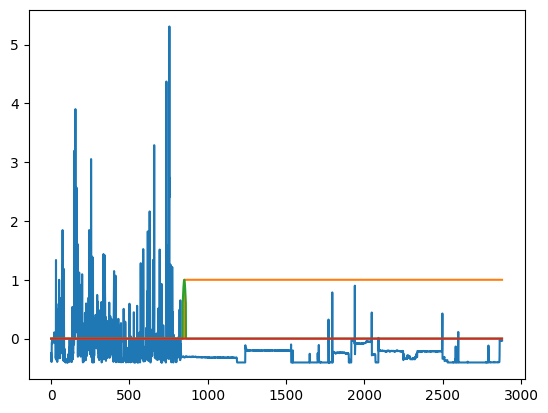

In [5]:
idx = 2
s_id = batch['series_id'][idx]
x = batch['feature'][idx]
y = batch['label'][idx]

plt.plot(x[1, ::cfg.downsample_rate])
plt.plot(y)
plt.show()

torch.Size([1, 3, 64, 2880])


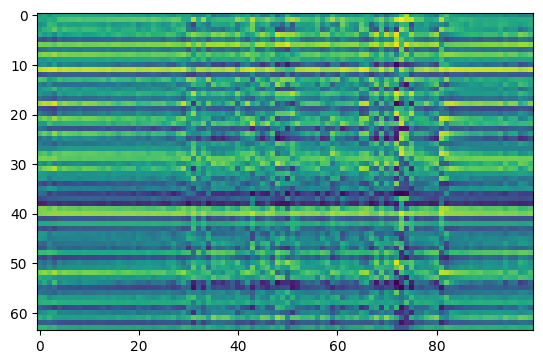

torch.Size([1, 64, 2880])


In [6]:
out = feature_extractor(x.unsqueeze(0))  # (batch_size, n_channels, height, n_timesteps)
print(out.shape)
plt.imshow(out[0, 2:, :, :100].permute((1, 2, 0)).detach().numpy())
plt.show()
out = encoder(out).squeeze(1)  # (batch_size, height, n_timesteps)
print(out.shape)
logits = decoder(out)[0]  # (batch_size, n_classes, n_timesteps)

torch.Size([2880, 3])


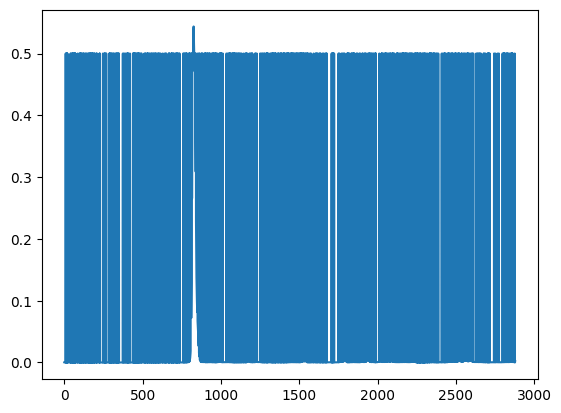

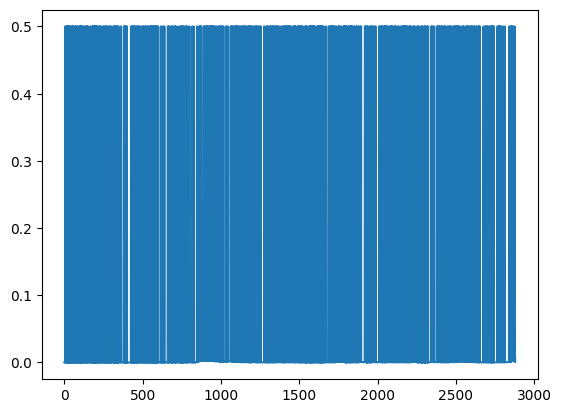

In [7]:
pred = logits.sigmoid()
print(pred.shape)
# pred[torch.where(pred < 0.5001)] = 0
pred = pred.detach().numpy()
plt.plot(pred[::1,1:2])
# plt.plot(x[1, ::cfg.downsample_rate])
plt.show()
plt.plot(pred[::1,2:])
# plt.plot(x[1, ::cfg.downsample_rate])
plt.show()

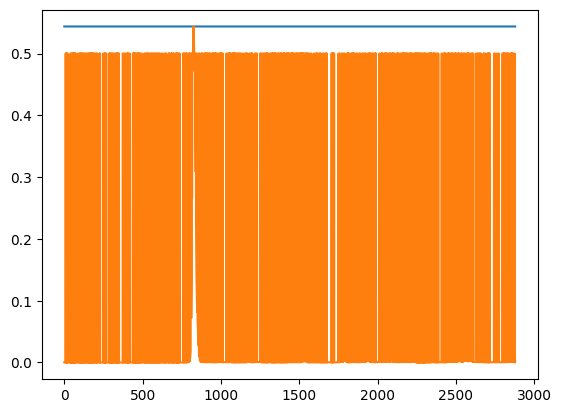

In [144]:
import numpy as np
dim = 1
plt.plot(np.ones_like(pred[:,dim])*pred[:,dim].max())
plt.plot(pred[:,dim])
plt.show()

In [140]:
from scipy.signal import find_peaks
find_peaks(pred[:,dim], height=0.02, distance=64)

(array([826]), {'peak_heights': array([0.1755195])})

In [72]:
pred

array([[1.1448452e-03, 8.2449267e-05, 5.7612779e-04],
       [7.4496886e-05, 3.8230773e-06, 5.0000000e-01],
       [5.0000000e-01, 5.0000000e-01, 1.0843164e-05],
       ...,
       [5.0000000e-01, 1.9563067e-04, 6.2253966e-05],
       [9.4002543e-04, 1.2877224e-04, 1.9407351e-05],
       [7.3204846e-03, 1.3542842e-03, 5.0000000e-01]], dtype=float32)